# Lab 3: Trees and SVMs


This lab uses the Python package [`graphviz`](https://pypi.org/project/graphviz). If you are using your own machine and using conda for installation do: `conda install conda-forge::python-graphviz`

In [15]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_openml

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

import graphviz

## 1) Decision Trees

Decision trees are a very simple machine learning technique that can be surprisingly powerful and offer a much more easily interpretable decision making process than many other methods. As the name suggests, decision trees are comprised of a set of nodes in a tree structure. All non-terminal nodes are called *decision nodes* which typically have two child nodes and contain a conditional expression involving a single feature of the input data. For a given input, starting at the root node, this condition is evaluated and this determines which of the two child nodes are selected for evaluation next. Once a *leaf node* is reached, the decision tree is able to produce an output class (classification) or a target value (regression). In this lab we will focus on the case of classification tasks.

For a given dataset of input-output pairs, there are a number of ways to construct a decision tree that can accurately classify the set of examples. We will be using the implementation of decision trees from the scikit-learn library which uses the CART (Classification And Regression Tree) algorithm with (by default) the Gini impurity criterion (see [this](https://victorzhou.com/blog/gini-impurity/) for simple explanation of Gini impurity). The CART algorithm can be summarised as follows:
1. **Obtaining the root node**: Test the possible splits of the dataset using conditions involving each of the input features and measure the Gini impurity of each split. The root node is given by the split that minimises the weighted sum of the Gini impurities of the two branches. The weights are equal to the number of data points that satisfy the condition of the corresponding branch.
2. **Creating the remaining decision nodes**: Iteratively follow the same process as step 1 using only the data points that match the conditions necessary to reach this point in the tree.
3. **Creating the leaf nodes**: These nodes are created when one of the stopping criteria is met. This set of criteria includes the case where all points of each class have been completely separated by a split (i.e. when the impurity is 0) or when some maximum depth has been reached.
4. **Pruning**: The tree can then be 'pruned' back to a smaller tree in an attempt to prevent overfitting. The degree of pruning can be selected using either a validation set or cross-validation. Note however that the scikit-learn method `DecisionTreeClassifier.fit` by default does **no** pruning (but you can turn pruning on by setting `ccp_alpha` to a positive value).

### 1.1) Training a Decision Tree Classifier

To start off, we will load in a classification dataset from scikit-learn: [the famous iris flower dataset](https://scikit-learn.org/stable/auto_examples/datasets/plot_iris_dataset.html#sphx-glr-auto-examples-datasets-plot-iris-dataset-py), compiled by Ronald Fisher in 1936. This is often used as a toy dataset for machine learning and contains three classes (species of Iris) with a number of named features such as petal length and width. The code below loads in the iris dataset but also includes the code to load in several other datasets that you can test your decision tree or ensemble methods on. These are commented out for now but you may wish to explore them later.

In [16]:
dataset = datasets.load_iris()
#dataset = datasets.load_wine()
#dataset = datasets.load_digits()

X = np.array(dataset['data'])
X_feature_names = dataset['feature_names']
y = np.array(dataset['target'])
y_target_names = dataset['target_names']

# 60% training, 20% dev and 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8) 
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size = 0.25, random_state=8)

### 1.1) Training a Decision Tree Classifier

Use scikit-learn to train a [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier), (with no pruning) assigning it the variable name `model`, on the Iris dataset and compute its accuracy score on both the training and test set.

In [17]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
print("Acc training:", model.score(X_train, y_train))
print("Acc test:", model.score(X_test, y_test))

Acc training: 1.0
Acc test: 0.9


Is the model overfitting to the training data?

*Yes, as the accuracy on the test set is a little lower than on the training set.*

### 1.2) Visualise the tree

The code below has been provided to create a visualisation for your decision tree. This cell will also print out a number of examples from the test set along with your tree's predictions to help you understand how the classification is being made. Run the cell and try to answer the questions that follow.

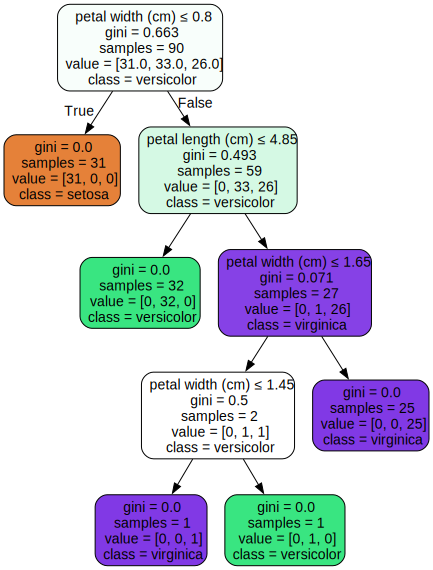

sepal length (cm) | sepal width (cm)  | petal length (cm) | petal width (cm)  | Label             | Prediction
--------------------------------------------------------------------------------------------------------------
5.0               | 3.6               | 1.4               | 0.2               | setosa            | setosa
4.7               | 3.2               | 1.6               | 0.2               | setosa            | setosa
5.2               | 3.5               | 1.5               | 0.2               | setosa            | setosa
6.9               | 3.1               | 5.1               | 2.3               | virginica         | virginica
6.7               | 3.1               | 4.4               | 1.4               | versicolor        | versicolor
4.9               | 3.1               | 1.5               | 0.2               | setosa            | setosa
5.1               | 3.3               | 1.7               | 0.5               | setosa            | setosa
6.7               | 3.

In [18]:
# Visualise the Decision Tree
dot_data = sklearn.tree.export_graphviz(model, out_file=None, feature_names=X_feature_names, class_names=y_target_names, filled=True, rounded=True, special_characters=True)  
graph = graphviz.Source(dot_data)
graph.render("iris")
display(graph)

# Print examples from the test dataset
wdth = max([len(name) for name in X_feature_names] + [len(lab) for lab in y_target_names]) + 1
print('| '.join([f'{X_feature_names[i]: <{wdth}}' for i in range(len(X_feature_names))] + [f'{"Label":<{wdth}}', "Prediction"]))
print('-'*110)
predicted_labels = model.predict(X_test)
num_examples = 15
for example, label, predicted_label in zip(X_test[:num_examples], y_test[:num_examples], predicted_labels[:num_examples]):
    print('| '.join([f'{example[i]: <{wdth}}' for i in range(len(example))] + [f'{y_target_names[label]: <{wdth}}', f'{y_target_names[predicted_label]}']))

Try to answer the following questions for your tree (note that taking the left path from a decision node corresponds to the condition in that node being true):
1. What features are most informative for identifying the Iris Setosa species and what values must they have? *Petal width <= 0.8*
3. What features can be used to discriminate between Iris Virginica and Iris Versicolor if the petals are longer than 4.75cm (hint: look at the paths through the decision tree from root to leaf)?
4. Choose one of the examples from the data set and follow the path that would be taken by the decision tree to produce a classification.
5. If we had more training data, which decision nodes do you think are most likely to change (hint: look at numbers of samples)?
6. Which decision nodes do you think may lead to the most errors if we deploy this model on a new test dataset? 

### 1.3) Train a decision tree for MNIST

For the iris dataset, we saw that our classifier was able to perform extremely well because of the dataset's simplicity. In this section, we will try to apply a decision tree to a more challenging dataset, the MNIST handwritten digits (as seen in week 5).

In [19]:
# load the MNIST data
X_mnist, y_mnist = fetch_openml(name='mnist_784',return_X_y=True, as_frame=False)
frac_of_dataset = 0.5
index = int(frac_of_dataset*X_mnist.shape[0])
X_train, X_test, y_train, y_test = train_test_split(X_mnist[:index,:], y_mnist[:index], test_size=0.2, random_state=5)

Just like you did before, create and train a decision tree using scikit-learn and using the variable name `model`.

In [22]:
model = DecisionTreeClassifier(ccp_alpha=100)
model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=100)

### 1.4) Compute the model's accuracy on MNIST train and test sets 

Compare the performance on train and test sets.

In [23]:
print("Accuracy train:", model.score(X_train, y_train))
print("Accuracy test:", model.score(X_test, y_test))

Accuracy train: 0.11442857142857144
Accuracy test: 0.114


Is the model overfitting on the MNIST data? What happens if you set the pruning parameter `ccp_alpha` to, say, a high positive value?

*Yes, it's overfitting.*

*ccp_alpha=100 causes tons of pruning, and now it's no longer overfitting*

## 2) Support vector machines (SVM)

In [24]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_moons
from matplotlib.colors import ListedColormap

In a parametric appoach a fixed number parameters are learn using training data which is then discarded and the learnt model used to make prediction on new data. In this section we implement support vector machines, a nonparametric model where the number of parameters are not fixed in advanced but grow with the amount of data.

A support vector machine constructs a hyper-plane to separate classes by maximising the distance (or margin) to the nearest training data points of any class. The figure below shows the decision boundary for linearly separable data, with three instances on the margin boundaries, called “support vectors”.

<img src="images/svm.png" style="width:450px;height:300px;">

<caption><center> <u>Figure 4</u>: SVM decision boundary, margin and support vectors.</center></caption>

For data that is not linearly separable, SVM classification involves quadratic programming optimisation to maximise the margin while incurring a penalty for each sample within the margin or a misclassification. The penalty strength is controlled by the hyperparameter `C`, a regularisation parameter that scales inversely.

SVMs can perform non-linear classification using the kernel trick. The kernel function maps the non-linear data into a feature space in which the linear support vector regression model is fit. But SVMs do this without ever constructing a new data set in feature space.

For more information on SVMs, see Bishop section 7.1.

The exercise for SVM classification involves a toy dataset generated in the cell below:

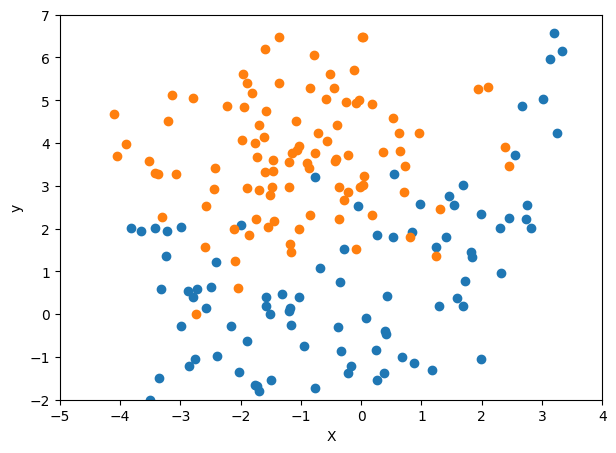

In [25]:
np.random.seed(0)
N = 100
x1 = np.linspace(-4,3.5,N).reshape(-1,1) + np.random.normal(0,0.2,N).reshape(-1,1)
y1 = np.exp(0.6*x1) - 1 + np.random.normal(0,1.5,N).reshape(-1,1)
x2 = np.random.normal(-1, 1.5, N).reshape(-1,1)
y2 = np.random.normal(4, 1.5, N).reshape(-1,1)

fig, ax = plt.subplots(figsize=(7, 5))
ax.scatter(x1,y1)
ax.scatter(x2,y2)
ax.set_xlim([-5,4])
ax.set_ylim([-2,7])
ax.set_xlabel('X')
ax.set_ylabel('y')
plt.show()

### Logistic regression classifier
A logistic regression classifier has been implemented on the toy dataset below, clearly not suitable for the non-linear data.

Logistic regression classifier accuracy: 0.82


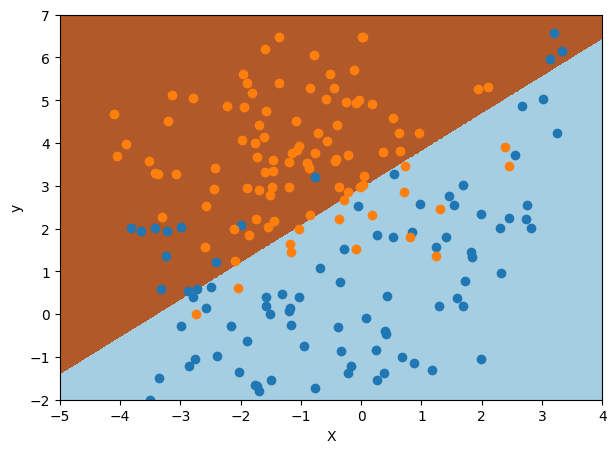

In [26]:
X = np.concatenate((np.concatenate((x1,x2)), np.concatenate((y1,y2))), axis=1)
Y = np.concatenate((np.zeros(N),np.ones(N)))
# blue = 0, orange = 1

def plot_clf(clf):
    h = 0.01
    xx, yy = np.meshgrid(np.arange(-5, 4, h), np.arange(-2, 7, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.Paired, shading='auto')
    ax.scatter(x1,y1)
    ax.scatter(x2,y2)
    ax.set_xlim([-5,4])
    ax.set_ylim([-2,7])
    ax.set_xlabel('X')
    ax.set_ylabel('y')
    
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X, Y)
print(f'Logistic regression classifier accuracy: {logreg.score(X, Y)}')
plot_clf(logreg)
plt.show()

### 2.1) SVM classifier
Implement a SVM classifier using scikit-learn [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC) and the `plot_clf` function defined in the previous cell.

Experiment with the hyperparameter `C` considering overfitting and generalisation. How would you tune `C`?

Accuracy train:  0.905


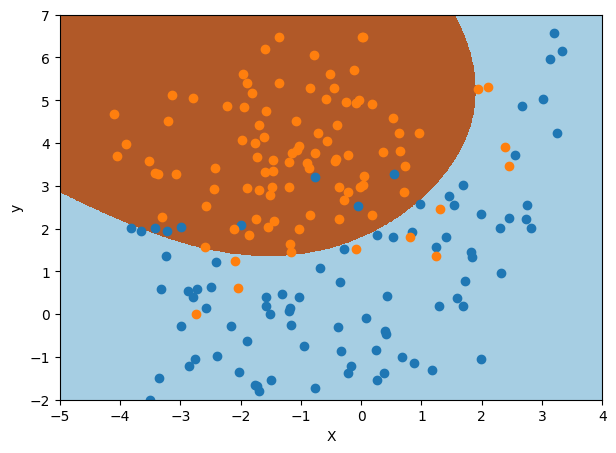

In [27]:
svc = SVC()
svc.fit(X, Y)
print("Accuracy train: ", svc.score(X, Y))
plot_clf(svc)

## 3) Classifier comparison
We are now going to compare the classifiers introduced above on a toy dataset plotted below. 

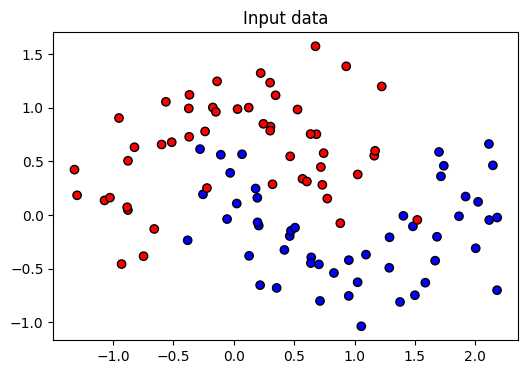

In [28]:
X, y = make_moons(noise=0.3, random_state=0)

fig, ax = plt.subplots(figsize=(6, 4))
# Plot the points
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
ax.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k')
ax.set_title("Input data")
plt.show()

The task is to train 4 classifiers on the dataset and compare the respective decision boundaries using a [contour](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contourf.html) plot, as shown below in figure 5.

<img src="images/contour.png" style="width:800px;height:200px;">

<caption><center> <u>Figure 5</u>: Example contour plot.</center></caption>

In [29]:
names = ["Logistic Regression", "Neural Net", "Linear SVM", "RBF SVM"]
              
classifiers = [
    LogisticRegression(C=1e5),
    MLPClassifier(alpha=1, max_iter=1000),    
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1)]

# create meshgrid
x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
h = .02  # step size in the mesh
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# colour map (contourf cmap parameter)
cm = plt.cm.RdBu

def Z_mesh(clf):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    if hasattr(clf, "decision_function"):
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
    else:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]        
    return Z.reshape(xx.shape)

The classifiers, with initial hyperparameters, are defined above. To help with making the contour plot, a [meshgrid](https://numpy.org/doc/stable/reference/generated/numpy.meshgrid.html) has been defined along with a `Z_mesh` function that returns the decision probability or decision output for the classifier for every point in the meshgrid.

In [ ]:
for cls in classifiers:
    cls.fit(X, y)

fig, axs = plt.subplots(1, 4)
fig.set_size_inches(17, 4)
for i in range(4):
    axs[i].set_title(names[i])
    axs[i].contourf(xx, yy, Z_mesh(classifiers[i]))
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    axs[i].scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright, edgecolors='k', zorder=1)

## Wrap up

- Experiments with classification trees and looking into overfitting.
- Support Vector Machine classification was used to fit a non-linear decision boundary and overfitting was explored.

### References
- Bishop Pattern Recognition and Machine Learning: Chapter 7 for support vector machines. 

